In [22]:
options(warn=-1)
library(forecast)
library(tseries)
library(astsa)


In [2]:
data <- read.csv("../input/weekly/weekly_climate.txt")

La série qu'on va traiter est la température moyenne de Delhi. Notre jeu de données contient des données de météo de 2013 à 2017 échantillonnées chaque mois ainsi que des caractéristiques météorologiques supplémentaires telles que la pression, l'humidité, etc.


In [3]:
head(data)

,date,meantemp,humidity,wind_speed,meanpressure
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,2013-01-01,7.604762,83.29524,2.903810,1017.686
2,2013-01-08,13.176871,66.51190,8.013265,1015.942
3,2013-01-15,13.409524,80.06803,4.471905,1017.973
4,2013-01-22,12.848639,64.74830,4.981973,1019.885
5,2013-01-29,16.107653,70.27959,3.396378,1016.555
6,2013-02-05,15.635034,70.97466,8.058946,1017.324


In [4]:
tail(data)

,date,meantemp,humidity,wind_speed,meanpressure
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
220,2017-03-14,22.20962,53.31935,7.872741,1012.396
221,2017-03-21,27.75238,42.35952,10.662262,1010.076
222,2017-03-28,30.34637,35.46769,9.259666,1006.324
223,2017-04-04,28.42764,29.09575,12.672740,1007.434
224,2017-04-11,30.49206,30.51786,6.395040,1004.810
225,2017-04-18,33.43214,30.55374,8.624393,1001.479


In [5]:
summary(data)

     date              meantemp         humidity       wind_speed     
 Length:225         Min.   : 7.605   Min.   :23.82   Min.   : 0.9929  
 Class :character   1st Qu.:18.554   1st Qu.:50.68   1st Qu.: 4.9346  
 Mode  :character   Median :27.752   Median :62.38   Median : 7.1161  
                    Mean   :25.232   Mean   :60.42   Mean   : 6.9036  
                    3rd Qu.:31.102   3rd Qu.:71.89   3rd Qu.: 8.7982  
                    Max.   :37.293   Max.   :91.80   Max.   :14.8972  
  meanpressure   
 Min.   : 857.2  
 1st Qu.:1001.7  
 Median :1009.0  
 Mean   :1010.6  
 3rd Qu.:1015.2  
 Max.   :1964.5  

On transforme notre donnée en objet série dans R 

In [6]:
ts <- ts(data$meantemp, frequency = 52)

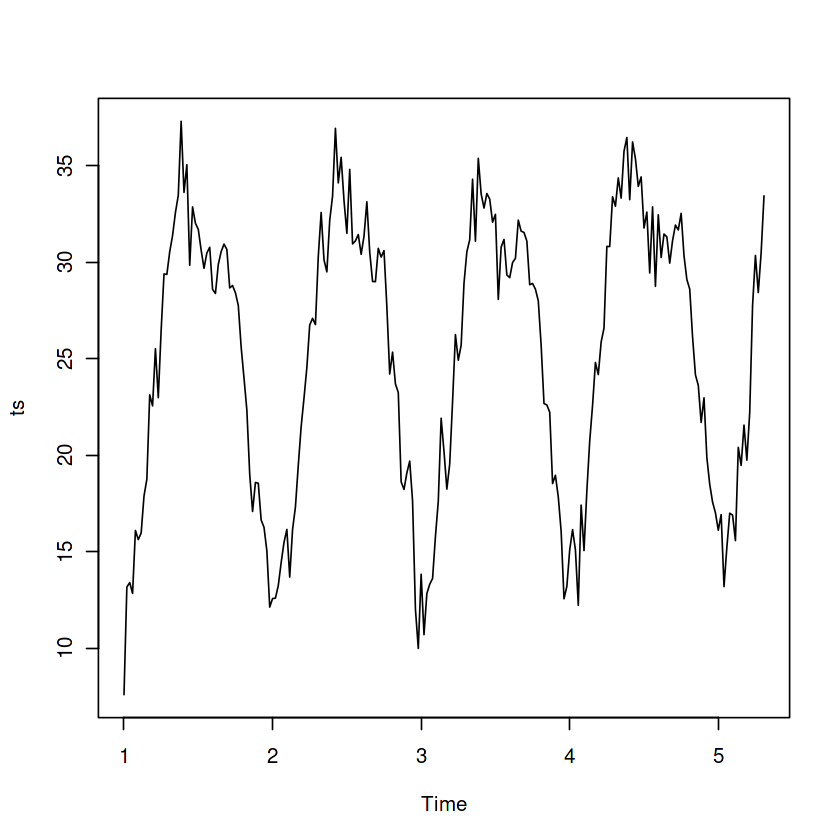

In [7]:
plot.ts(ts)

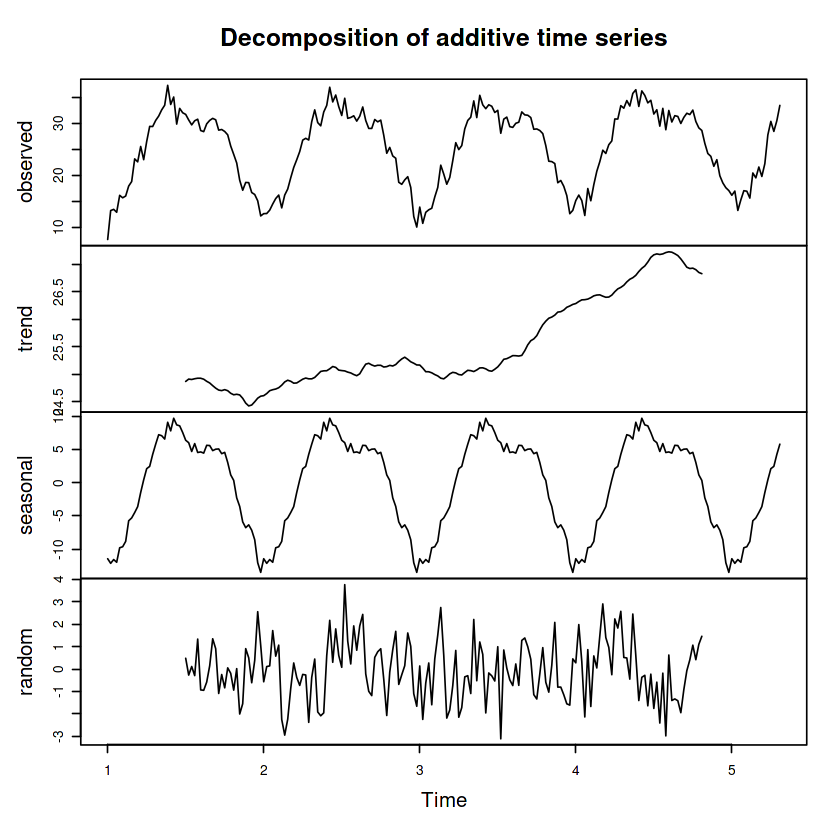

In [8]:
ts.decomp.ad <- decompose(ts, type = "additive")
plot(ts.decomp.ad)

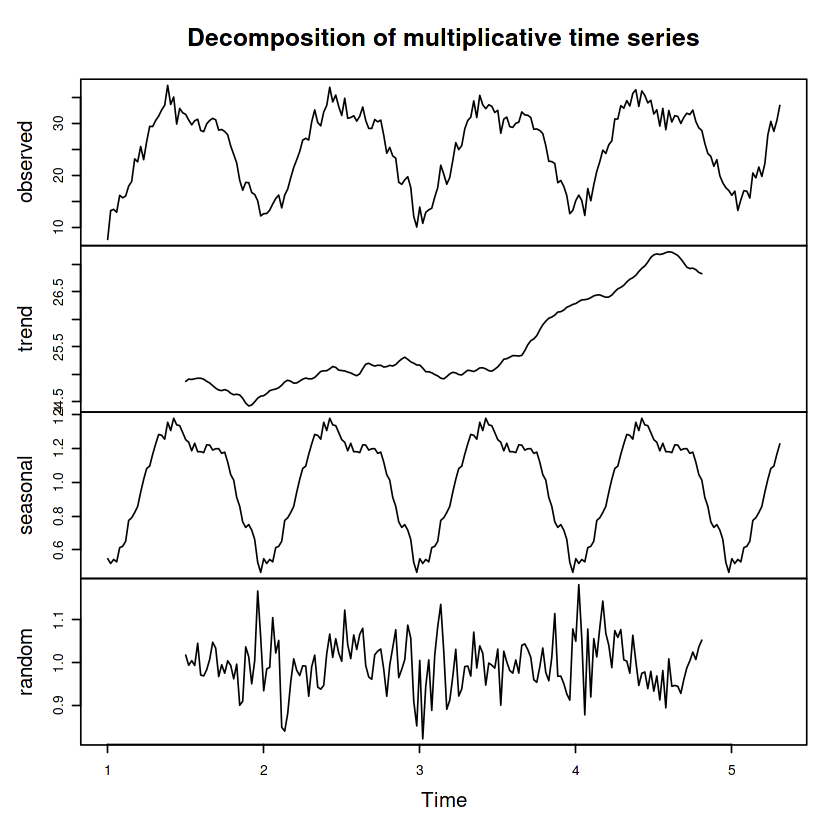

In [9]:
ts.decomp.mu <- decompose(ts, type = "multiplicative")
plot(ts.decomp.mu)

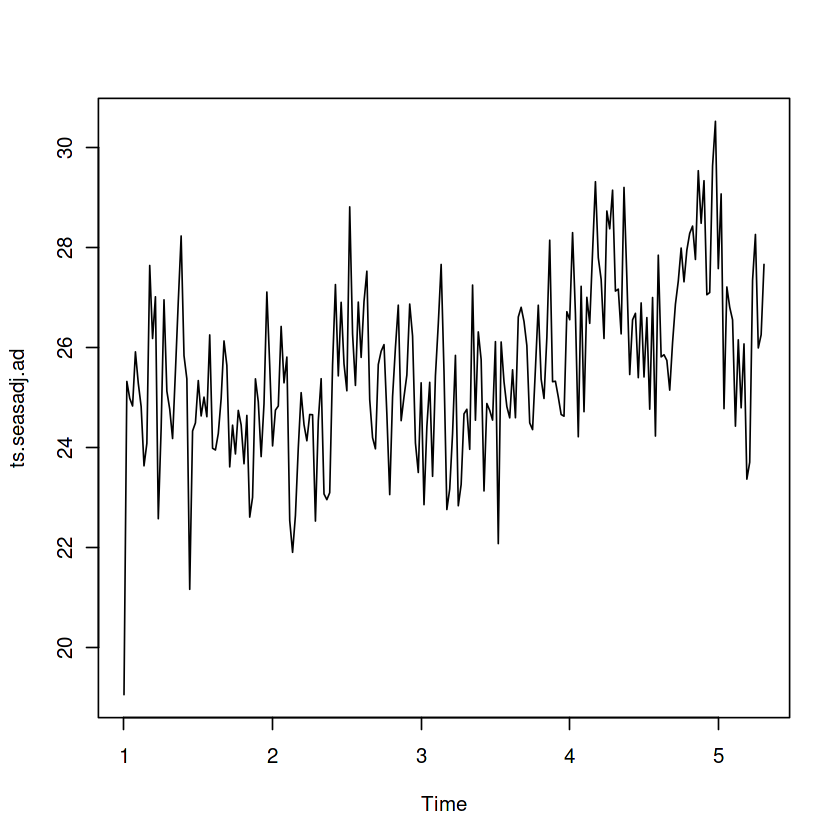

In [10]:
ts.seasadj.ad <- ts - ts.decomp.ad$seasonal
plot.ts(ts.seasadj.ad)

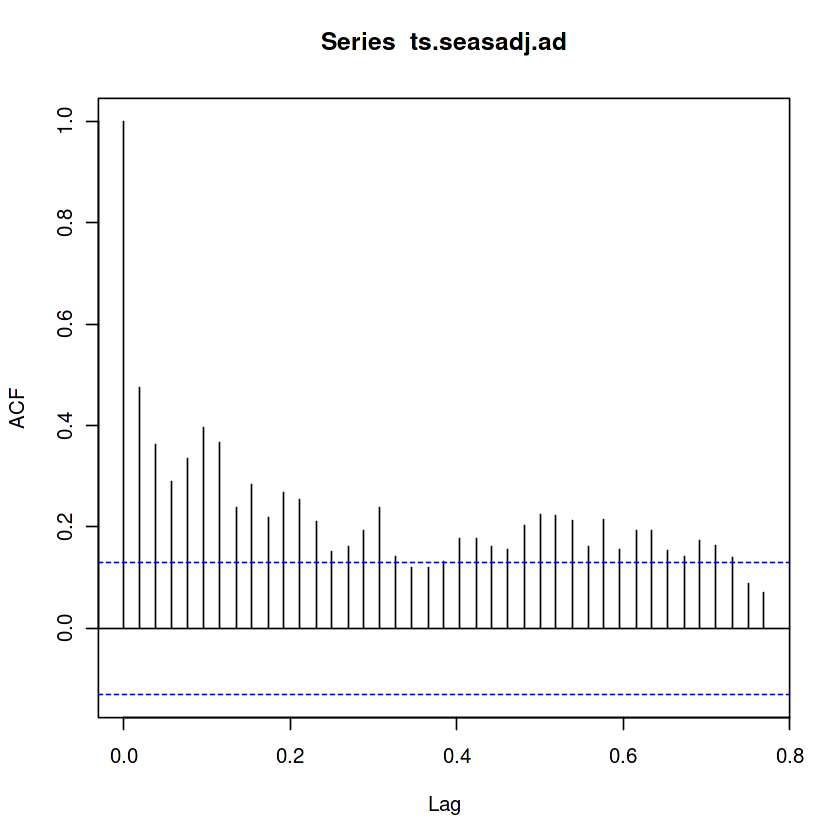

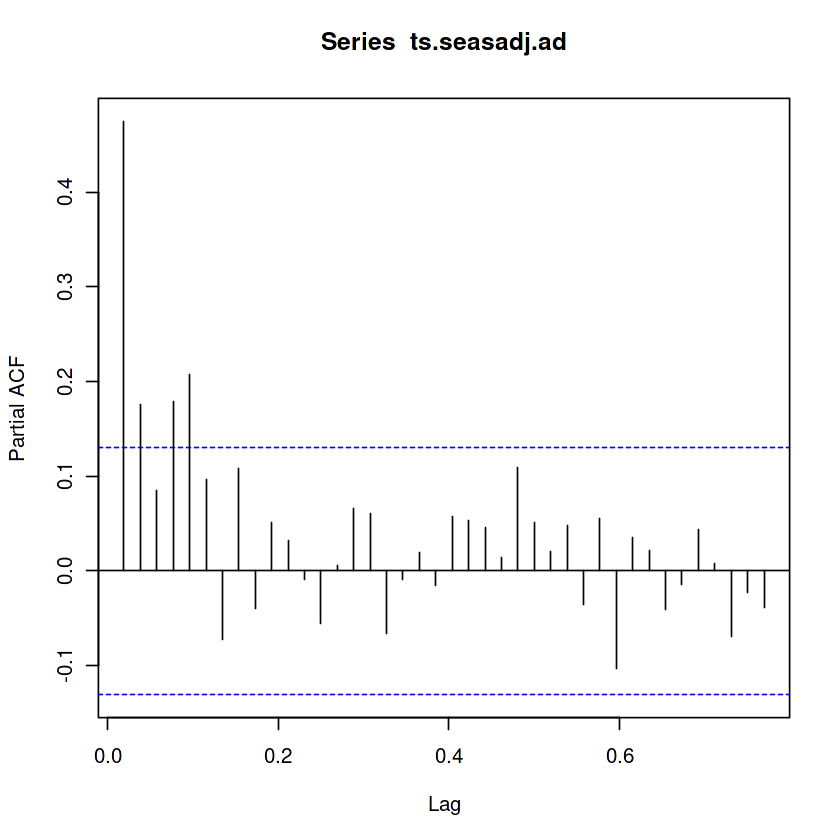

In [11]:
acf(ts.seasadj.ad, lag.max = 40)
pacf(ts.seasadj.ad, lag.max = 40)

In [12]:
adf.test(ts, alternative = "stationary", k = 0)


	Augmented Dickey-Fuller Test

data:  ts
Dickey-Fuller = -2.7835, Lag order = 0, p-value = 0.247
alternative hypothesis: stationary


p-value = 0.24 > 0.05 -> notre serie n'est pas stationaire

In [13]:
adf.test(log(ts), alternative = "stationary", k = 0)


	Augmented Dickey-Fuller Test

data:  log(ts)
Dickey-Fuller = -3.6585, Lag order = 0, p-value = 0.02865
alternative hypothesis: stationary


La serie devient stationaire lorsqu'on fait une transformation logarithmique

In [14]:
split1<- sample(c(rep(0, 0.8 * nrow(data)), rep(1, 0.2 * nrow(data))))
train <- data[split1 == 0,]
test <- data[split1 == 1,]

On prend 80% de série pour l'entrainment et 20% pour la validation

In [15]:
ts.train <- log(ts(train$meantemp, frequency = 52))
ts.test <- log(ts(test$meantemp, frequency = 52))


Call:
arima(x = ts.train, order = c(7, 0, 0), transform.pars = TRUE)

Coefficients:
         ar1     ar2     ar3      ar4      ar5      ar6      ar7  intercept
      0.7865  0.2426  0.0971  -0.0396  -0.0015  -0.0240  -0.1861     3.1687
s.e.  0.0801  0.1027  0.1046   0.1053   0.1067   0.1041   0.0823     0.0611

sigma^2 estimated as 0.01034:  log likelihood = 154.24,  aic = -290.48

Training set error measures:
                      ME      RMSE        MAE         MPE     MAPE      MASE
Training set 0.002362041 0.1016867 0.07361898 -0.02402401 2.474341 0.8978575
                    ACF1
Training set -0.08189939

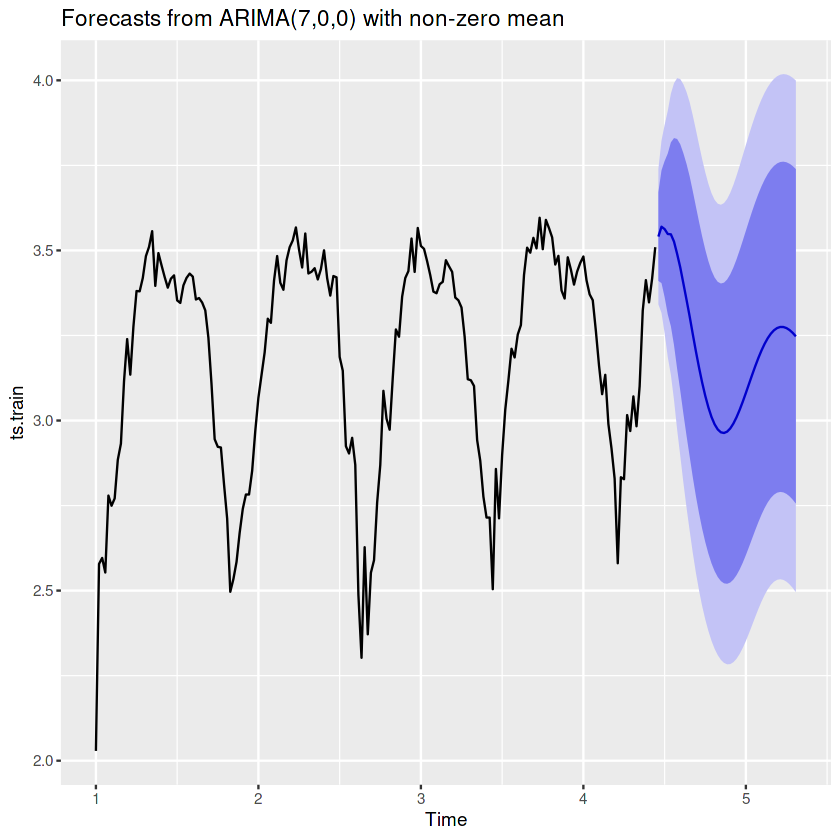

In [16]:
ar <- arima(ts.train, order=c(7,0,0), transform.pars = TRUE)
summary(ar)
forecast <- forecast(ar, h=length(ts.test))
autoplot(forecast)


Call:
arima(x = ts.train, order = c(0, 0, 3), transform.pars = TRUE)

Coefficients:
         ma1     ma2     ma3  intercept
      1.0128  0.9277  0.5933     3.1745
s.e.  0.0632  0.0701  0.0601     0.0369

sigma^2 estimated as 0.01991:  log likelihood = 96.01,  aic = -182.02

Training set error measures:
                      ME      RMSE       MAE        MPE     MAPE     MASE
Training set 0.004159579 0.1411022 0.1073267 -0.2445002 3.594677 1.308957
                  ACF1
Training set 0.1010842

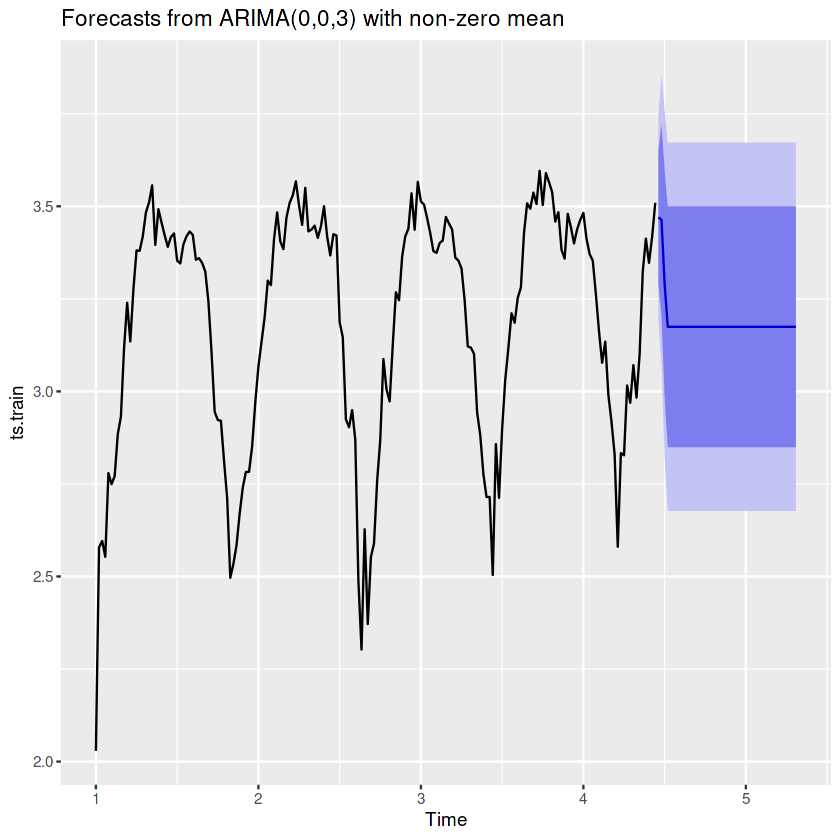

In [17]:
ma <- arima(ts.train, order=c(0,0,3), transform.pars = TRUE)
summary(ma)
forecast <- forecast(ma, h=length(ts.test))
autoplot(forecast)


Call:
arima(x = ts.train, order = c(7, 0, 3))

Coefficients:
         ar1     ar2     ar3     ar4      ar5      ar6     ar7     ma1      ma2
      0.1949  1.0374  0.7591  -0.713  -0.3767  -0.1079  0.1051  0.6216  -0.3760
s.e.  0.0992  0.0964  0.1229   0.149   0.1205   0.0979  0.0963  0.0641   0.0894
          ma3  intercept
      -0.9026     3.1858
s.e.   0.0601     0.0265

sigma^2 estimated as 0.009551:  log likelihood = 158.92,  aic = -293.83

Training set error measures:
                       ME       RMSE        MAE        MPE     MAPE      MASE
Training set -0.001878339 0.09772736 0.07204508 -0.1512744 2.409079 0.8786623
                    ACF1
Training set -0.05727507

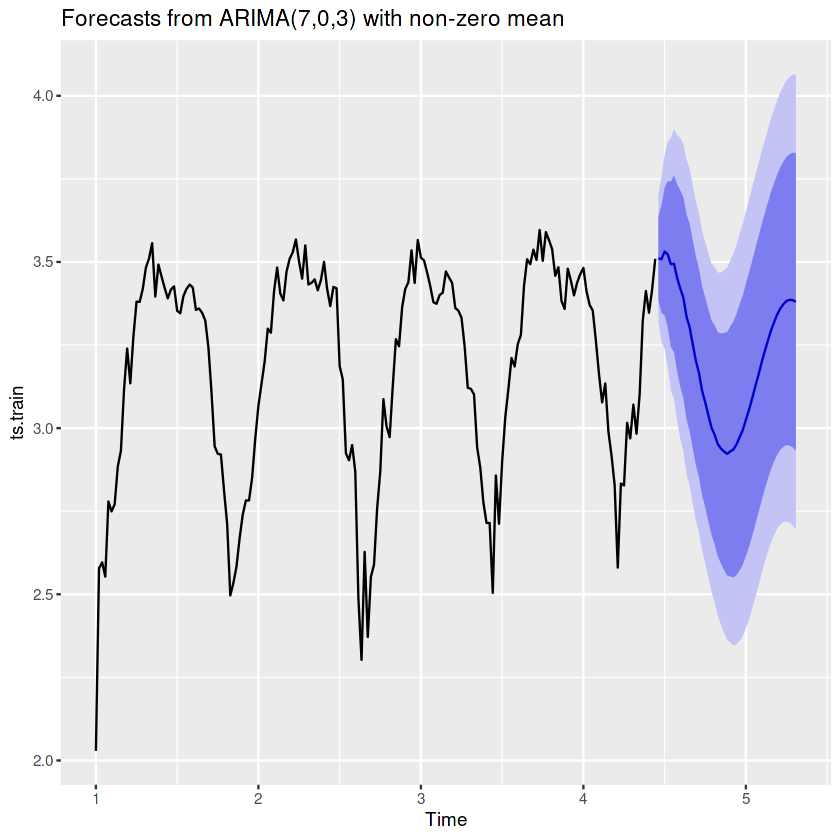

In [18]:
arma <- arima(ts.train, order=c(7,0,3))
summary(arma)
forecast <- forecast(arma, h=length(ts.test))
autoplot(forecast)


Call:
arima(x = ts.train, order = c(7, 1, 3))

Coefficients:
         ar1      ar2     ar3      ar4     ar5     ar6      ar7      ma1
      1.3279  -0.4566  0.1762  -0.0279  0.0484  0.0042  -0.1614  -1.5405
s.e.  0.5008   0.6521  0.2306   0.1488  0.1490  0.1437   0.1305   0.5047
         ma2      ma3
      0.8190  -0.2676
s.e.  0.7457   0.3072

sigma^2 estimated as 0.01037:  log likelihood = 153.4,  aic = -284.8

Training set error measures:
                     ME      RMSE        MAE       MPE     MAPE      MASE
Training set 0.01763803 0.1015694 0.07556697 0.5051567 2.493309 0.9216152
                    ACF1
Training set 0.007738814

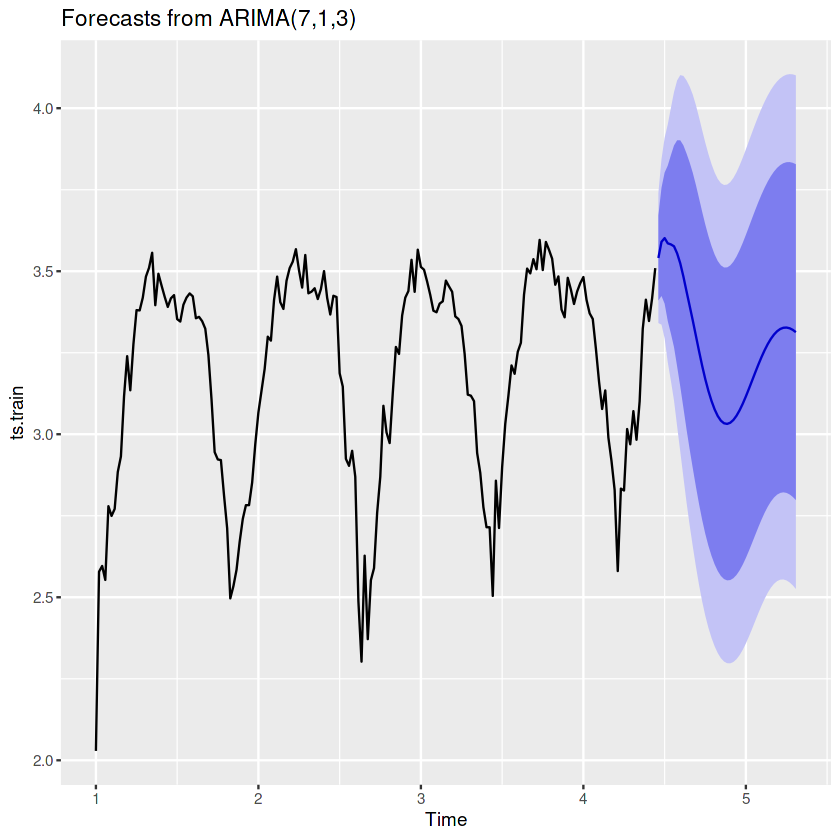

In [19]:
arima <- arima(ts.train, order=c(7,1,3))
summary(arima)
forecast <- forecast(arima, h=length(ts.test))
autoplot(forecast)


Call:
arima(x = ts.train, order = c(7, 0, 3), seasonal = list(order = c(0, 0, 0), 
    period = 52))

Coefficients:
         ar1     ar2     ar3     ar4      ar5      ar6     ar7     ma1      ma2
      0.1949  1.0374  0.7591  -0.713  -0.3767  -0.1079  0.1051  0.6216  -0.3760
s.e.  0.0992  0.0964  0.1229   0.149   0.1205   0.0979  0.0963  0.0641   0.0894
          ma3  intercept
      -0.9026     3.1858
s.e.   0.0601     0.0265

sigma^2 estimated as 0.009551:  log likelihood = 158.92,  aic = -293.83

Training set error measures:
                       ME       RMSE        MAE        MPE     MAPE      MASE
Training set -0.001878339 0.09772736 0.07204508 -0.1512744 2.409079 0.8786623
                    ACF1
Training set -0.05727507

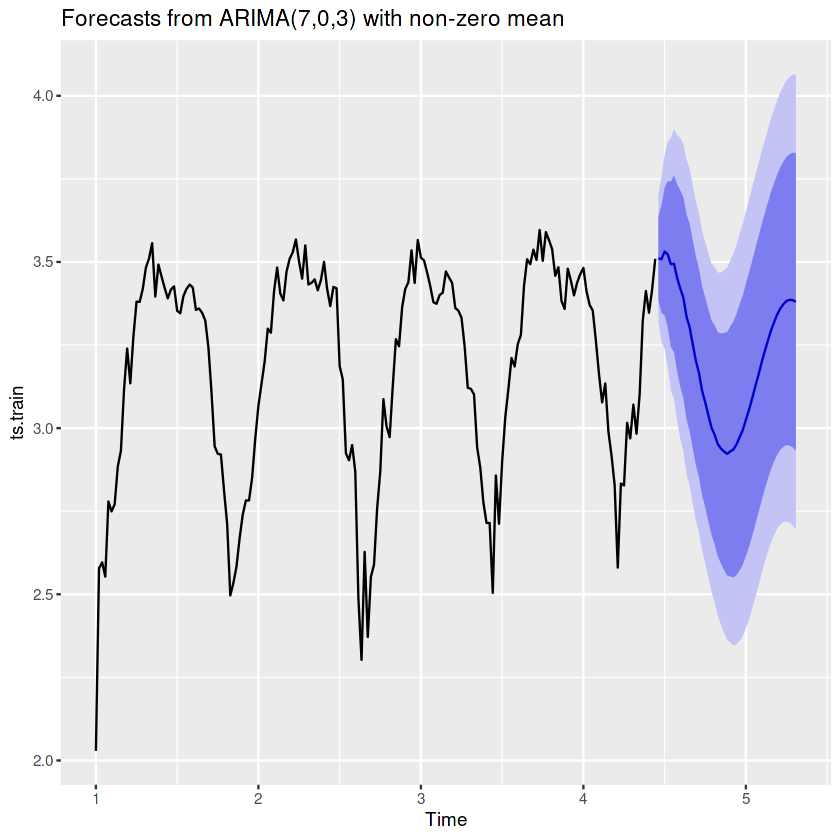

In [20]:
sarima <- arima(ts.train, order=c(7,0,3), seasonal = list(order = c(0,0,0), period = 52))
summary(sarima)
forecast <- forecast(sarima, h=length(ts.test))
autoplot(forecast)

In [21]:
min(ar$aic, ma$aic, arma$aic, arima$aic, sarima$aic)

[1] -293.8319